### DSC vs. NSD, as appropriate, by organ

#### Most basic - needs csv

In [7]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df_metric = pd.read_csv("organ_perf_dsc_merged.csv")

# Display the first few rows
print(df_metric.head())


    case  organ     value        algo
0  s0001  aorta  0.896496  _Diff-UNet
1  s0006  aorta  0.968756  _Diff-UNet
2  s0009  aorta  0.982722  _Diff-UNet
3  s0012  aorta  0.889999  _Diff-UNet
4  s0013  aorta  0.979722  _Diff-UNet


In [8]:
unique_organs = df_metric["organ"].unique()

for org in unique_organs:
    # Subset just this organ
    sub_df = df_metric[df_metric["organ"] == org]

    # Group by algo, compute mean of value
    agg_df = (
        sub_df
        .groupby("algo", as_index=False)["value"]
        .mean()
        .rename(columns={"value": "mean_value"})
    )

    # Sort descending if bigger metric => better
    agg_df = agg_df.sort_values("mean_value", ascending=False)

    # Assign a rank (1 = best)
    agg_df["rank"] = range(1, len(agg_df) + 1)

    print("=== Organ:", org, "===")
    print(agg_df.to_string(index=False))
    print()


=== Organ: aorta ===
                           algo  mean_value  rank
              nnU-Net_STU-Net_L    0.740417     1
              nnU-Net_STU-Net_H    0.726646     2
              nnU-Net_STU-Net_B    0.718101     3
                nnU-Net_ResEncL    0.713468     4
                nnU-Net_MedNeXt    0.695329     5
                  nnU-Net_U-Net    0.684460     6
                     _MedFormer    0.678518     7
                 nnU-Net_UniSeg    0.673310     8
                 nnU-Net_NexToU    0.595173     9
                  MONAI_LHU-Net    0.591955    10
                     _Diff-UNet    0.577087    11
                   MONAI_SegVol    0.576092    12
     Vision_Language_U-Net_CLIP    0.574811    13
Vision_Language_Swin_UNETR_CLIP    0.565573    14
                    MONAI_UNEST    0.515975    15
               MONAI_Swin_UNETR    0.511609    16
               MONAI_UCTransNet    0.481466    17
                    MONAI_UNETR    0.368090    18
                   _SAM-Adapt

### Reimplementation of R code in Py

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform

# Path to parent folder containing one subfolder per algorithm
parent_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# List subdirectories (one per algorithm)
model_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Our 9 organs of interest
all_organs = ["aorta", "gall_bladder", "kidney_left", "kidney_right",
              "liver", "pancreas", "postcava", "spleen", "stomach"]

# Decide which metric to use for each organ: DSC vs NSD
organs_use_nsd = {"aorta", "postcava"}
organs_use_dsc = set(all_organs) - organs_use_nsd

# Directory to save plots (optional)
out_plots_dir = "organ_plots"
os.makedirs(out_plots_dir, exist_ok=True)


def read_metric_data(metric, organs):
    """
    Read the CSV data from each algorithm folder and pivot to long format.

    Parameters:
        metric (str): "dsc" or "nsd"
        organs (list): List of organs to extract

    Returns:
        pd.DataFrame: Combined long-format data from all algorithm results
    """
    all_data = []

    for mdir in model_dirs:
        csv_file = os.path.join(mdir, f"{metric}.csv")
        if not os.path.exists(csv_file):
            print(f"Skipping: no {metric}.csv in {mdir}")
            continue

        df = pd.read_csv(csv_file)

        if 'name' not in df.columns:
            print(f"Skipping: {csv_file} missing 'name' column")
            continue

        df_long = df.melt(id_vars=['name'], value_vars=organs, var_name='organ', value_name='value')
        df_long.rename(columns={'name': 'case'}, inplace=True)
        df_long['algo'] = os.path.basename(mdir)

        # Remove rows with NaN values
        df_long = df_long.dropna()

        all_data.append(df_long)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame(columns=['case', 'organ', 'value', 'algo'])


def compute_ranking(df):
    """
    Compute ranking of algorithms using statistical significance.

    Parameters:
        df (pd.DataFrame): Dataframe containing algorithm performance

    Returns:
        pd.DataFrame: Dataframe with ranking per algorithm
    """
    algo_means = df.groupby('algo')['value'].mean()
    rankings = rankdata(-algo_means, method='min')  # Higher value = better rank
    rank_df = pd.DataFrame({'algo': algo_means.index, 'mean_score': algo_means.values, 'rank': rankings})
    return rank_df.sort_values(by='rank')


def bootstrap_ranking(df, nboot=200):
    """
    Perform bootstrapping to compute rank distributions.

    Parameters:
        df (pd.DataFrame): Algorithm performance data
        nboot (int): Number of bootstrap samples

    Returns:
        pd.DataFrame: Bootstrapped rank distributions
    """
    boot_ranks = []
    algos = df['algo'].unique()

    for _ in range(nboot):
        sample = df.sample(frac=1, replace=True)
        rank_sample = compute_ranking(sample)
        boot_ranks.append(rank_sample[['algo', 'rank']])

    boot_df = pd.concat(boot_ranks)
    return boot_df


# Store results (tables/plots) in a dictionary
results_per_organ = {}

for org in all_organs:
    # Decide which metric to use
    metric_choice = "nsd" if org in organs_use_nsd else "dsc"

    # Read data for the organ
    df_metric = read_metric_data(metric_choice, [org])

    if df_metric.empty:
        print(f"No data found for organ {org} with metric={metric_choice} -- skipping.")
        continue

    # Compute ranking
    rank_df = compute_ranking(df_metric)

    # Perform bootstrapping for violin plot
    boot_df = bootstrap_ranking(df_metric, nboot=200)

    # Generate Figures

    ## Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_metric, x='algo', y='value', showfliers=False)
    sns.stripplot(data=df_metric, x='algo', y='value', jitter=True, alpha=0.6, color='black')
    plt.xticks(rotation=90)
    plt.title(f"Boxplot for {org} using {metric_choice.upper()}")
    plt.xlabel("Algorithm")
    plt.ylabel(metric_choice.upper())
    plt.savefig(os.path.join(out_plots_dir, f"box_{org}_{metric_choice}.png"), dpi=300, bbox_inches='tight')
    plt.close()

    ## Significance Map (Fixed)
    algos = rank_df['algo'].values
    ranks = rank_df['rank'].values.reshape(-1, 1)
    rank_matrix = squareform(pdist(ranks, metric='euclidean'))  # Pairwise ranking distances

    sig_df = pd.DataFrame(rank_matrix, index=algos, columns=algos)

    plt.figure(figsize=(8, 6))
    sns.heatmap(sig_df, annot=True, cmap="coolwarm", cbar=True)
    plt.title(f"Significance Map for {org} ({metric_choice.upper()})")
    plt.savefig(os.path.join(out_plots_dir, f"sigmap_{org}_{metric_choice}.png"), dpi=300, bbox_inches='tight')
    plt.close()

    ## Violin Plot of Bootstrapped Ranks
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=boot_df, x='rank', y='algo', inner="quartile")
    plt.title(f"Violin of Ranks: {org} ({metric_choice})")
    plt.savefig(os.path.join(out_plots_dir, f"violin_{org}_{metric_choice}.png"), dpi=300, bbox_inches='tight')
    plt.close()

    # Store results
    results_per_organ[org] = {
        "organ": org,
        "metric": metric_choice,
        "ranking_df": rank_df,
        "bootstrap_ranks": boot_df
    }

print("Processing completed. Results saved.")

Processing completed. Results saved.


## Model Rankings

### DSC & NSD across all organs

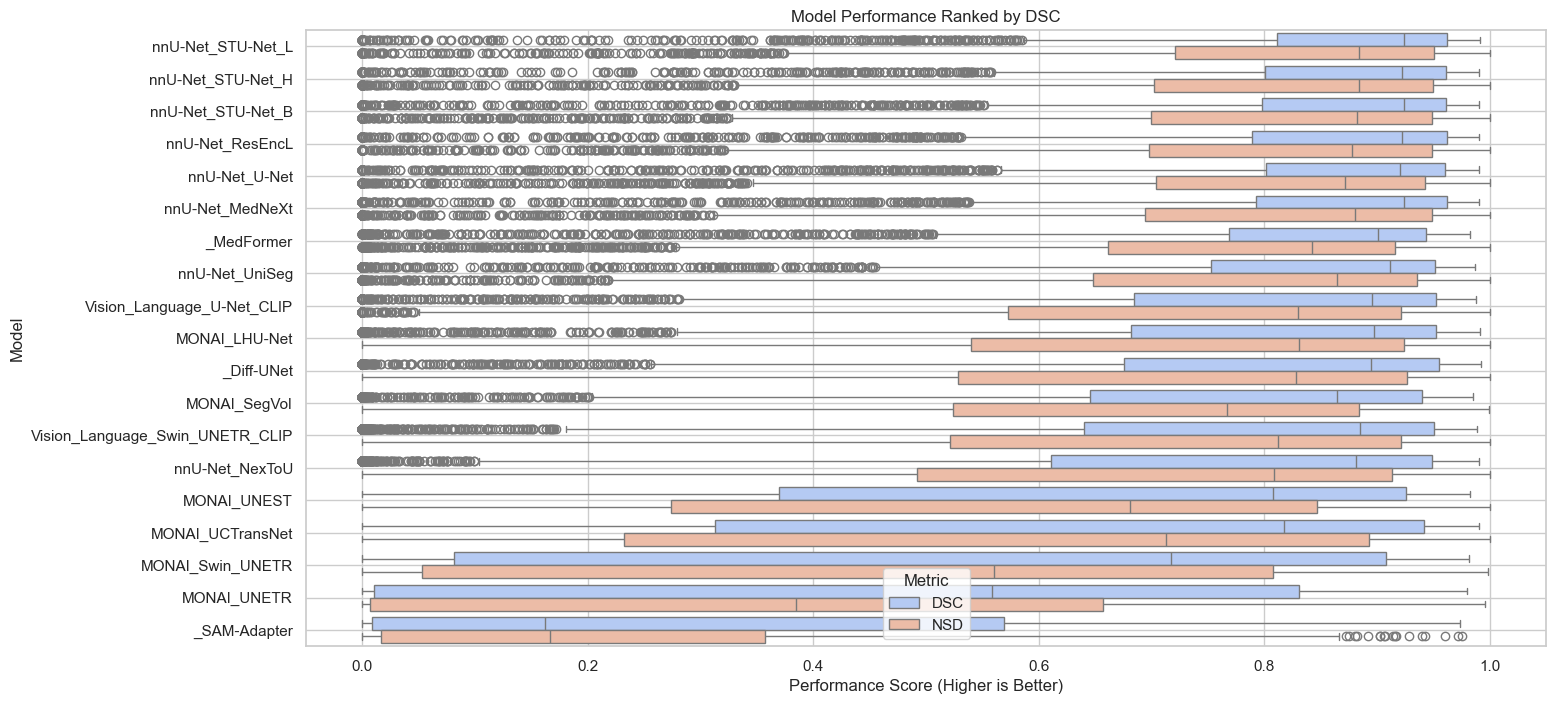

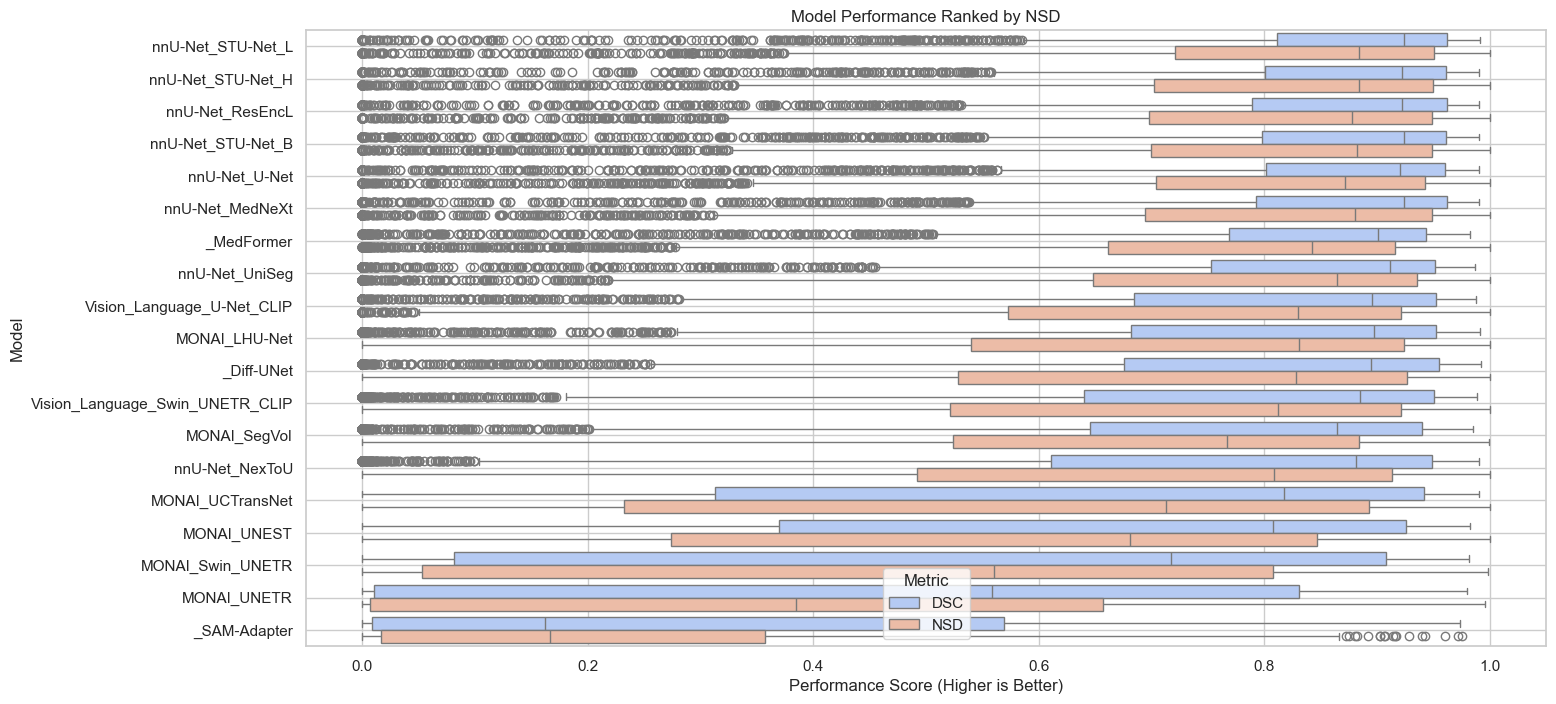

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to store all data
all_model_data = []

# Define the extracted directory path
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# List all model directories (ignore metadata file)
model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Read and aggregate data from each model's DSC and NSD files
for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if it exists
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')  # Remove case names if present
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")  # Aggregate across organs
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)  # Remove NaN values
        all_model_data.append(df_dsc)

    # Read NSD file if it exists
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')  # Remove case names if present
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")  # Aggregate across organs
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)  # Remove NaN values
        all_model_data.append(df_nsd)

# Merge all collected data
df_all_models = pd.concat(all_model_data, ignore_index=True)

# Compute mean performance per model & metric
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

# Sort models separately for DSC and NSD rankings
dsc_sorted_models = model_ranking[model_ranking["metric"] == "DSC"].sort_values(by="value", ascending=False)["model"]
nsd_sorted_models = model_ranking[model_ranking["metric"] == "NSD"].sort_values(by="value", ascending=False)["model"]

# Plot: Box plot ranked by DSC performance
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_all_models,
    x="value",
    y="model",
    hue="metric",
    showfliers=True,
    palette="coolwarm",
    order=dsc_sorted_models  # Ranked by DSC
)
plt.xlabel("Performance Score (Higher is Better)")
plt.ylabel("Model")
plt.title("Model Performance Ranked by DSC")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

# Plot: Box plot ranked by NSD performance
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_all_models,
    x="value",
    y="model",
    hue="metric",
    showfliers=True,
    palette="coolwarm",
    order=nsd_sorted_models  # Ranked by NSD
)
plt.xlabel("Performance Score (Higher is Better)")
plt.ylabel("Model")
plt.title("Model Performance Ranked by NSD")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

#### Plots to highlight difference in Ranking

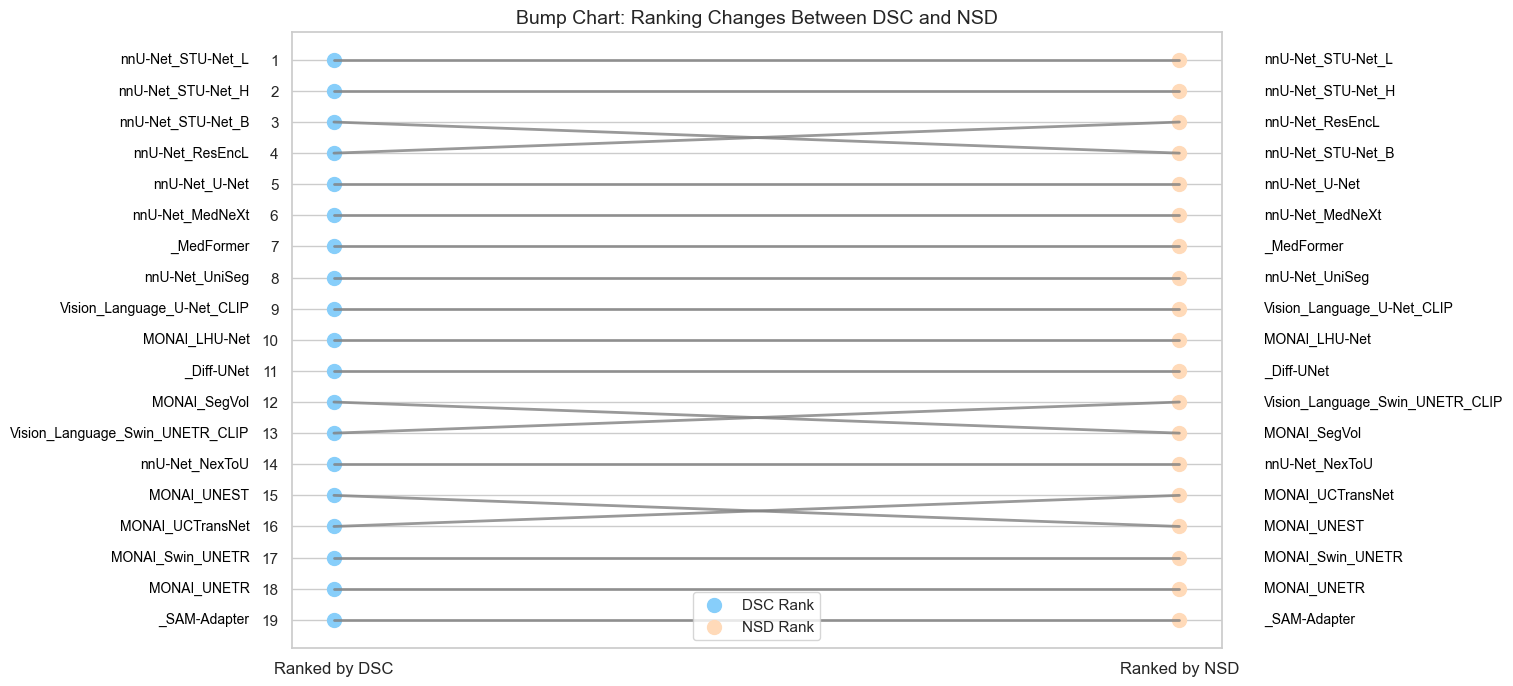

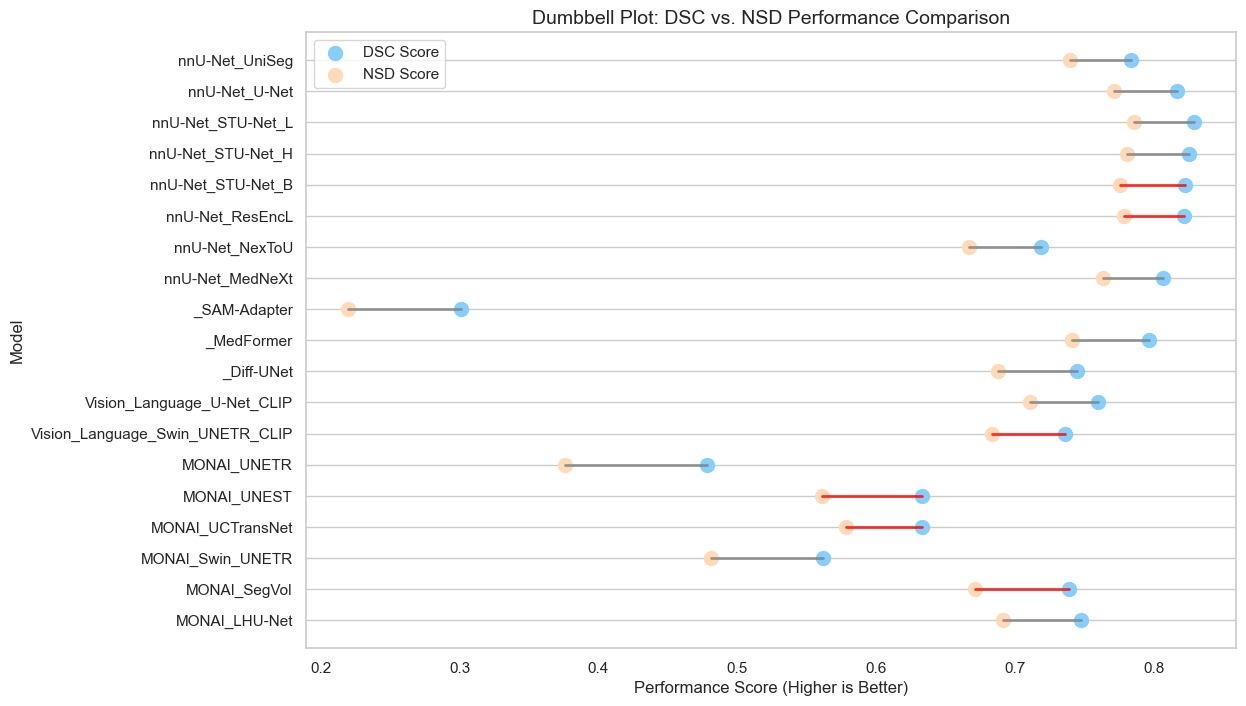

In [18]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# --- 2. Load Performance Data ---
all_model_data = []
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if available
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)
        all_model_data.append(df_dsc)

    # Read NSD file if available
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)
        all_model_data.append(df_nsd)

df_all_models = pd.concat(all_model_data, ignore_index=True)

# --- 3. Compute Model Rankings ---
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

dsc_ranking = model_ranking[model_ranking["metric"] == "DSC"].set_index("model")["value"].rank(ascending=False)
nsd_ranking = model_ranking[model_ranking["metric"] == "NSD"].set_index("model")["value"].rank(ascending=False)

rank_changes = (dsc_ranking - nsd_ranking).abs()
models_with_changes = rank_changes[rank_changes > 0].index.tolist()

# --- Define Colors to Match the Box Plots ---
PASTEL_BLUE   = "#87CEFA"  # DSC color
PASTEL_ORANGE = "#FFDAB9"  # NSD color
GRAY          = "gray"
RED           = "red"

# ----------------------------------------------------------------------
# 4. Bump Chart: Ranking Changes
# ----------------------------------------------------------------------
bump_chart_df = pd.DataFrame({
    "Model": dsc_ranking.index,
    "DSC Rank": dsc_ranking.values,
    "NSD Rank": nsd_ranking.loc[dsc_ranking.index].values
})

bump_chart_df["Rank Change"] = np.abs(bump_chart_df["DSC Rank"] - bump_chart_df["NSD Rank"])
# Decide when to highlight in red (here: >1 rank difference)
bump_chart_df["Highlight"] = bump_chart_df["Rank Change"] > 1

plt.figure(figsize=(12, 8))

# Draw connection lines between DSC Rank and NSD Rank
for _, row in bump_chart_df.iterrows():
    color_line = RED if row["Highlight"] else GRAY
    plt.plot([1, 2], [row["DSC Rank"], row["NSD Rank"]], color=color_line, linewidth=2, alpha=0.8)

# Scatter points for DSC
plt.scatter(
    np.ones(len(dsc_ranking)),
    dsc_ranking,
    color=PASTEL_BLUE,
    s=100,
    label="DSC Rank"
)

# Scatter points for NSD
plt.scatter(
    np.ones(len(nsd_ranking)) * 2,
    nsd_ranking,
    color=PASTEL_ORANGE,
    s=100,
    label="NSD Rank"
)

# Annotate model names
for _, row in bump_chart_df.iterrows():
    plt.text(0.9, row["DSC Rank"], row["Model"], ha="right", va="center", fontsize=10, color="black")
    plt.text(2.1, row["NSD Rank"], row["Model"], ha="left", va="center", fontsize=10, color="black")

plt.xticks([1, 2], ["Ranked by DSC", "Ranked by NSD"], fontsize=12)
plt.yticks(range(1, len(dsc_ranking) + 1))
plt.gca().invert_yaxis()  # Put Rank=1 at the top
plt.title("Bump Chart: Ranking Changes Between DSC and NSD", fontsize=14)
plt.legend()
plt.grid(axis="x")
plt.show()

# ----------------------------------------------------------------------
# 5. Dumbbell Plot: Performance Comparison
# ----------------------------------------------------------------------
dumbbell_df = model_ranking.pivot(index="model", columns="metric", values="value").reset_index()
dumbbell_df["Highlight"] = dumbbell_df["model"].isin(models_with_changes)

plt.figure(figsize=(12, 8))

# Draw dumbbell lines
for _, row in dumbbell_df.iterrows():
    color_line = RED if row["Highlight"] else GRAY
    plt.plot(
        [row["DSC"], row["NSD"]],
        [row["model"], row["model"]],
        color=color_line,
        linewidth=2,
        alpha=0.8
    )

# Scatter points for DSC
plt.scatter(
    dumbbell_df["DSC"],
    dumbbell_df["model"],
    color=PASTEL_BLUE,
    s=100,
    label="DSC Score"
)

# Scatter points for NSD
plt.scatter(
    dumbbell_df["NSD"],
    dumbbell_df["model"],
    color=PASTEL_ORANGE,
    s=100,
    label="NSD Score"
)

plt.xlabel("Performance Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Dumbbell Plot: DSC vs. NSD Performance Comparison", fontsize=14)
plt.legend()
plt.grid(axis="x")
plt.show()

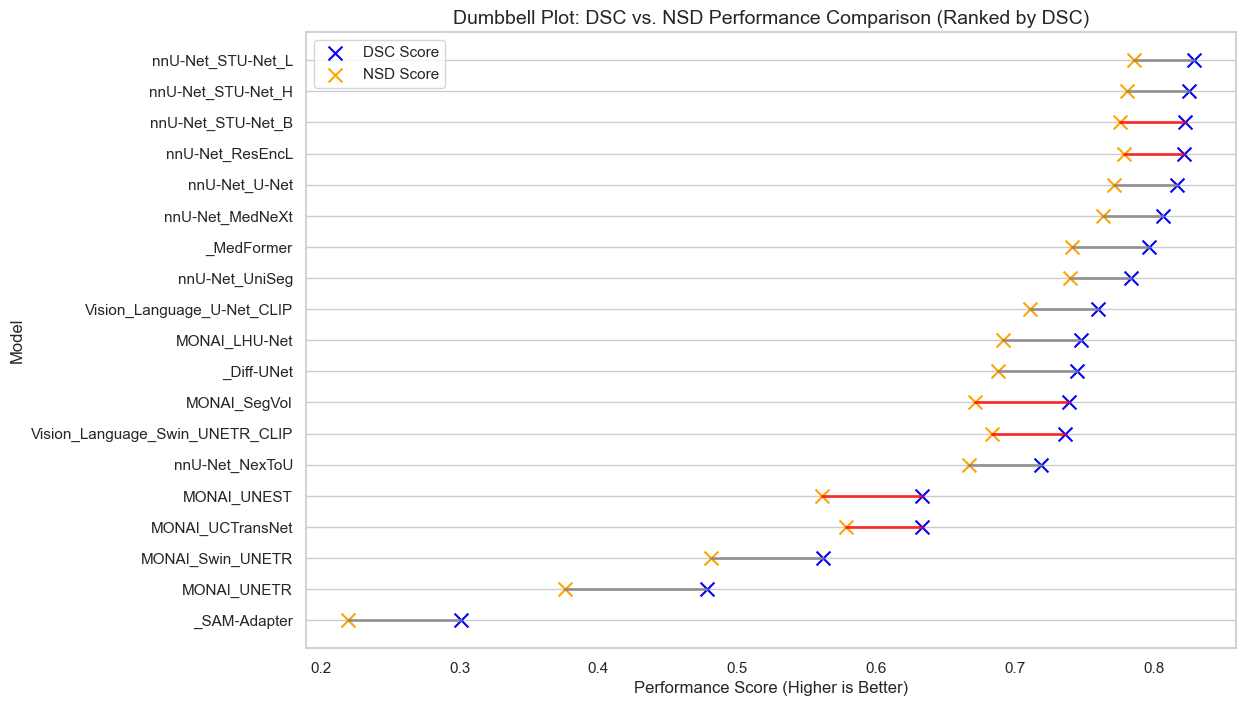

In [21]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# --- 2. Load Performance Data ---
all_model_data = []
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if available
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)
        all_model_data.append(df_dsc)

    # Read NSD file if available
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)
        all_model_data.append(df_nsd)

df_all_models = pd.concat(all_model_data, ignore_index=True)

# --- 3. Compute Model Rankings ---
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

# Rank models based on DSC and NSD performance
dsc_ranking = model_ranking[model_ranking["metric"] == "DSC"].set_index("model")["value"].rank(ascending=True)
nsd_ranking = model_ranking[model_ranking["metric"] == "NSD"].set_index("model")["value"].rank(ascending=True)

rank_changes = (dsc_ranking - nsd_ranking).abs()
models_with_changes = rank_changes[rank_changes > 0].index.tolist()

# ----------------------------------------------------------------------
# 4. Dumbbell Plot: Performance Comparison (Ranked by DSC)
# ----------------------------------------------------------------------

# Pivot the model rankings for dumbbell plot
dumbbell_df = model_ranking.pivot(index="model", columns="metric", values="value").reset_index()
dumbbell_df["Highlight"] = dumbbell_df["model"].isin(models_with_changes)

# Sort models by DSC ranking (best DSC model at the top)
sorted_models_by_dsc = dsc_ranking.sort_values().index
dumbbell_df_sorted = dumbbell_df.set_index("model").loc[sorted_models_by_dsc].reset_index()

# Define colors for dumbbell plot
BLUE = "blue"
ORANGE = "orange"
GRAY = "gray"
RED = "red"

plt.figure(figsize=(12, 8))

# Draw dumbbell lines
for _, row in dumbbell_df_sorted.iterrows():
    color = RED if row["Highlight"] else GRAY
    plt.plot([row["DSC"], row["NSD"]], [row["model"], row["model"]], color=color, linewidth=2, alpha=0.8)

# Scatter points for DSC (Blue X markers)
plt.scatter(dumbbell_df_sorted["DSC"], dumbbell_df_sorted["model"], color=BLUE, marker="x", s=100, label="DSC Score")

# Scatter points for NSD (Orange X markers)
plt.scatter(dumbbell_df_sorted["NSD"], dumbbell_df_sorted["model"], color=ORANGE, marker="x", s=100, label="NSD Score")

# Aesthetic settings
plt.xlabel("Performance Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Dumbbell Plot: DSC vs. NSD Performance Comparison (Ranked by DSC)", fontsize=14)
plt.legend()
plt.grid(axis="x")

# Show the dumbbell plot
plt.show()

#### Same but `o3-mini-high`

- Confirms weird looking plot. Need to check data, to match TS

https://chatgpt.com/share/67b89bc8-54d4-8006-a9cf-a6f9a4c80432

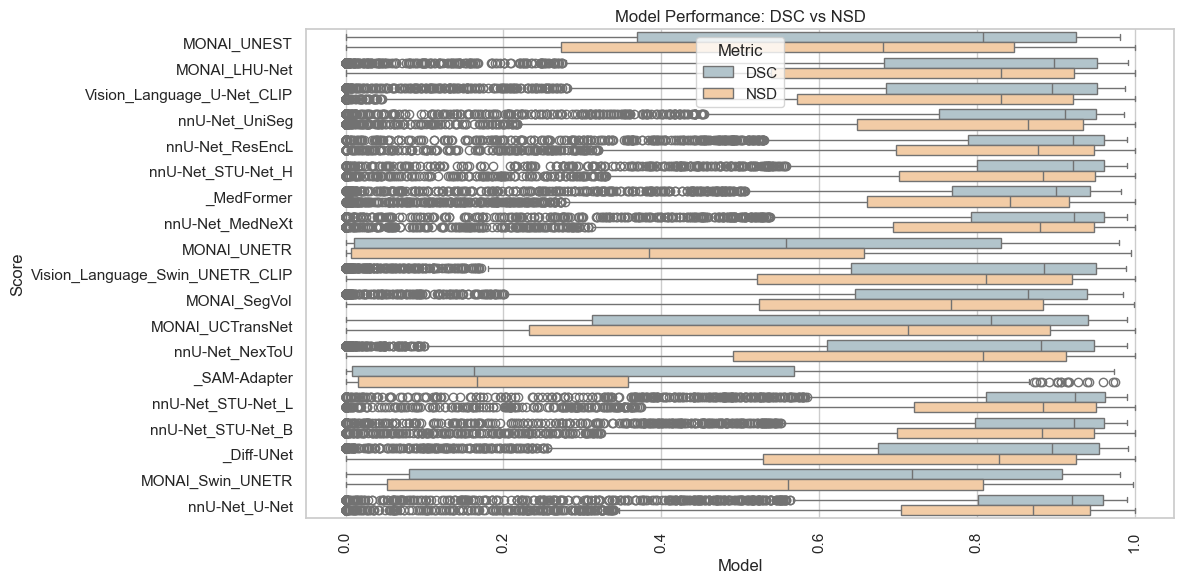

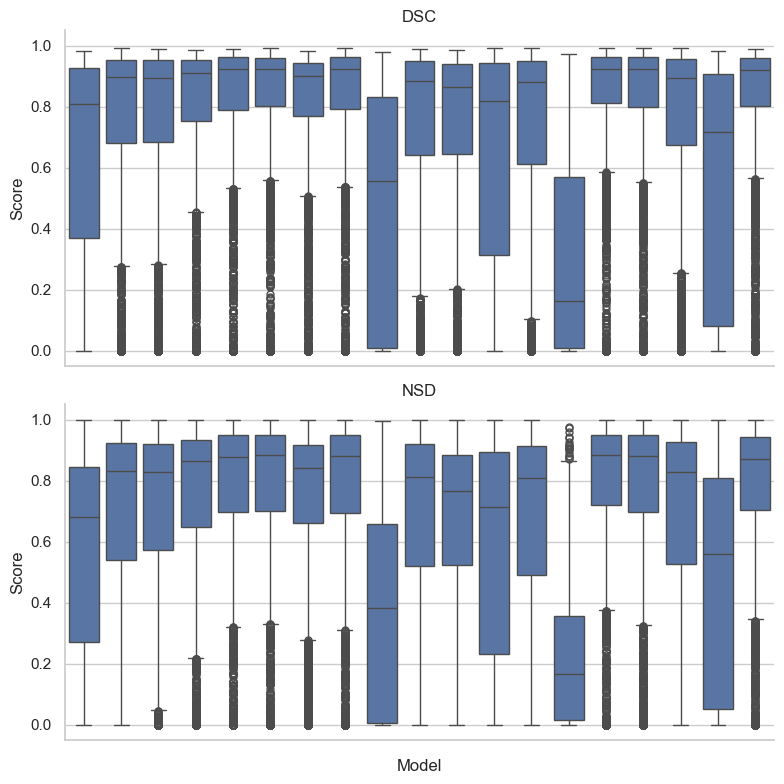

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List model directories (ignoring non-directory files)
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# Get a list of model directories (ignoring files like totalsegmentator_metadata.csv)
model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(d)]


model_dirs = os.listdir(base_dir)

# Prepare an empty list to store data
data_list = []

# Loop over each model directory
for model in model_dirs:
    dsc_path = os.path.join(base_dir, model, 'dsc.csv')
    nsd_path = os.path.join(base_dir, model, 'nsd.csv')
    if os.path.exists(dsc_path) and os.path.exists(nsd_path):
        # Load DSC data and flatten the per-organ scores
        df_dsc = pd.read_csv(dsc_path)
        dsc_values = pd.to_numeric(df_dsc.drop(columns='name').values.flatten(), errors='coerce')
        dsc_values = pd.Series(dsc_values).dropna()
        temp_dsc = pd.DataFrame({
            'model': model,
            'metric': 'DSC',
            'value': dsc_values
        })

        # Load NSD data and flatten
        df_nsd = pd.read_csv(nsd_path)
        nsd_values = pd.to_numeric(df_nsd.drop(columns='name').values.flatten(), errors='coerce')
        nsd_values = pd.Series(nsd_values).dropna()
        temp_nsd = pd.DataFrame({
            'model': model,
            'metric': 'NSD',
            'value': nsd_values
        })

        data_list.extend([temp_dsc, temp_nsd])
    else:
        print(f"Warning: Missing DSC or NSD file in {model}")

# Combine all the data into one DataFrame
df_all = pd.concat(data_list, ignore_index=True)

# Set up the colors: pastel orange for DSC, pastel blue for NSD
palette = {'DSC': '#aec6cf', 'NSD': '#ffcc99'}

# Create the boxplot with models on the x-axis and metrics as the hue
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='value', y='model', hue='metric', data=df_all, palette=palette)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: DSC vs NSD')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# boring plots

# Plot: we want a boxplot for each metric (DSC and NSD) in its own row.
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_all,
    x='model',
    y='value',
    col='metric',
    kind='box',
    col_wrap=1,     # one plot per row
    height=4,
    aspect=2
)

# Rotate x-axis labels so they are readable
g.set_xticklabels(rotation=90)
g.set_axis_labels("Model", "Score")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()